<a href="https://colab.research.google.com/github/BanceSt/StageRN/blob/master/CatsVsDogsClassique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from matplotlib.image import imread
from google.colab import drive
from tensorflow import keras
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy
import scipy.io.wavfile as wavfile
import sklearn
import sklearn.metrics
import seaborn as sns
import random
import math
import sklearn.utils
import sklearn.metrics
import matplotlib.pyplot as plt
import glob
import os
import scipy
import scipy.signal
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
import IPython
drive.mount('/content/drive')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!unzip "/content/drive/My Drive/dataStage/audio-cats-and-dogs.zip" -d /content/sample_data

Archive:  /content/drive/My Drive/dataStage/audio-cats-and-dogs.zip
  inflating: /content/sample_data/cats_dogs/cat_1.wav  
  inflating: /content/sample_data/cats_dogs/cat_10.wav  
  inflating: /content/sample_data/cats_dogs/cat_100.wav  
  inflating: /content/sample_data/cats_dogs/cat_101.wav  
  inflating: /content/sample_data/cats_dogs/cat_102.wav  
  inflating: /content/sample_data/cats_dogs/cat_103.wav  
  inflating: /content/sample_data/cats_dogs/cat_105.wav  
  inflating: /content/sample_data/cats_dogs/cat_106.wav  
  inflating: /content/sample_data/cats_dogs/cat_107.wav  
  inflating: /content/sample_data/cats_dogs/cat_108.wav  
  inflating: /content/sample_data/cats_dogs/cat_109.wav  
  inflating: /content/sample_data/cats_dogs/cat_11.wav  
  inflating: /content/sample_data/cats_dogs/cat_110.wav  
  inflating: /content/sample_data/cats_dogs/cat_112.wav  
  inflating: /content/sample_data/cats_dogs/cat_113.wav  
  inflating: /content/sample_data/cats_dogs/cat_114.wav  
  inflat

**Récupération des données :**

In [0]:
WAVE_FOLDER = '/content/sample_data/cats_dogs'
FRAMERATE = 16000
MAX_WAV_SAMPLES = 20*FRAMERATE
DOWNSAMPLING_SCALE = 1

df = pd.read_csv("/content/sample_data/train_test_split.csv")
test_cat = df[['test_cat']].dropna().rename(index=str, columns={"test_cat": "file"}).assign(label=0)
test_dog = df[['test_dog']].dropna().rename(index=str, columns={"test_dog": "file"}).assign(label=1)
train_cat = df[['train_cat']].dropna().rename(index=str, columns={"train_cat": "file"}).assign(label=0)
train_dog = df[['train_dog']].dropna().rename(index=str, columns={"train_dog": "file"}).assign(label=1)

test_df = pd.concat([test_cat, test_dog]).reset_index(drop=True)
train_df = pd.concat([train_cat, train_dog]).reset_index(drop=True)

**Partie qui servira à equilibre le nombre de cris de chats et de chiens**

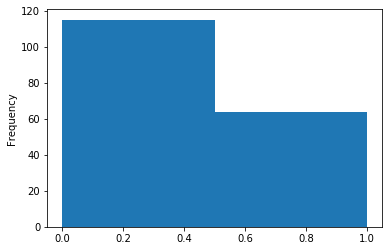

In [5]:
#Histogramme du nombre de cris par type d'animaux (chat, chien)
train_df['label'].plot.hist(bins=2)

In [6]:
#Equilibrage des nombres de cris dans train_files, train_labels
random_oversampler = RandomOverSampler()
idx = np.arange(0, len(train_df)).reshape(-1, 1)
idx_sampled, _ = random_oversampler.fit_sample(idx, train_df['label'])
train_files, train_labels = train_df.iloc[idx_sampled.flatten()]['file'].values, train_df.iloc[idx_sampled.flatten()]['label'].values
train_files, train_labels = sklearn.utils.shuffle(train_files, train_labels)
test_files, test_labels = test_df['file'].values, test_df['label'].values



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


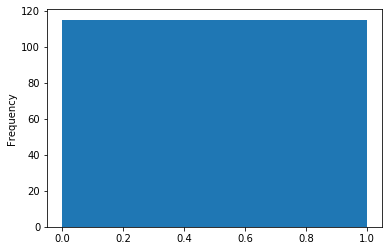

In [7]:
#Historigramme après équilibrage
pd.Series(train_labels).plot.hist(bins=2);

**Générateur qui seront utiliser sur le model**

In [0]:
#Génére des batch, et des labels pour l'apprentissage
def fit_generator(train_files, train_labels, wavs_per_batch=20, augments=5):
    while True:
        maxidx = len(train_files)
        for i in range(0, maxidx, wavs_per_batch):
            waves_batch = []
            labels_batch = []
            for j in range(i, min(maxidx, i+wavs_per_batch)):
                file, label = train_files[j], train_labels[j]
                wave_raw = wavfile.read(os.path.join(WAVE_FOLDER, file))[1]
                wave_raw = wave_raw/np.std(wave_raw)
                length = len(wave_raw)
                waves_batch.append(np.pad(wave_raw, pad_width=((0, MAX_WAV_SAMPLES - length)), mode='wrap'))
                labels_batch.append(label)
                for _ in range(augments):
                    wave_rotated = np.roll(wave_raw, random.randint(0, length))
                    while random.choice([True, False]):
                        wave_rotated += np.roll(wave_raw, random.randint(0, length))
                    wave = np.pad(wave_rotated, pad_width=((0, MAX_WAV_SAMPLES - length)), mode='wrap')
                    #wave = scipy.signal.decimate(wave, DOWNSAMPLING_SCALE)
                    waves_batch.append(wave)
                    labels_batch.append(label)
            yield np.array(waves_batch), np.array(labels_batch)



In [0]:
#Génére des batch, et des labels pour la validation
def validate_generator(test_files, test_labels, wavs_per_batch=20):
    while True:
        maxidx = len(test_files)
        for i in range(0, maxidx, wavs_per_batch):
            waves_batch = []
            labels_batch = []
            for j in range(i, min(maxidx, i+wavs_per_batch)):
                file, label = test_files[j], test_labels[j]
                wave_raw = wavfile.read(os.path.join(WAVE_FOLDER, file))[1]
                wave_raw = wave_raw/np.std(wave_raw)
                length = len(wave_raw)
                left = 0
                right = MAX_WAV_SAMPLES - left - length
                wave = np.pad(wave_raw, pad_width=((left, right)), mode='wrap')
                #wave = scipy.signal.decimate(wave, DOWNSAMPLING_SCALE)
                waves_batch.append(wave)
                labels_batch.append(label)
            yield np.array(waves_batch), np.array(labels_batch)

In [0]:
def steps_per_epoch(wavs_per_epoch, wavs_per_batch):
    return int(math.ceil(wavs_per_epoch/wavs_per_batch))

**Création du Model :**

In [11]:
#Création du model
def create_model() :
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Reshape((MAX_WAV_SAMPLES//DOWNSAMPLING_SCALE,1), input_shape=(MAX_WAV_SAMPLES//DOWNSAMPLING_SCALE,)))
  for i in range(14):
    model.add(tf.keras.layers.Conv1D(32, kernel_size=5, 
                                     padding='same',
                                     activation='relu',
                                     kernel_initializer=tf.keras.initializers.Orthogonal(),
                                     ))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=3, strides=2))
    model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(2, activation='softmax'))
  
  model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
                loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=['accuracy'])
  return model
  
model = create_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
WAVS_PER_BATCH = 3
AUGMENTS = 10
EPOCHS=15

**Mise en place des points de sauvegarde :**

In [13]:
checkpoint_path = "/content/drive/My Drive/savemodel/Model15chk/cp-{epoch:04d}"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

print(checkpoint_dir)

/content/drive/My Drive/savemodel/Model15chk


**Apprentissage et validation :**

In [14]:
#Apprentissage

model.save_weights(checkpoint_path.format(epoch=0))
model.fit_generator(fit_generator(train_files, train_labels, WAVS_PER_BATCH, AUGMENTS),
                    steps_per_epoch=steps_per_epoch(len(train_files), WAVS_PER_BATCH),
                    epochs = EPOCHS,
                    validation_data=validate_generator(test_files, test_labels, WAVS_PER_BATCH),
                    validation_steps=steps_per_epoch(len(test_files), WAVS_PER_BATCH),
                    callbacks = [cp_callback],
                    verbose=2)

Epoch 1/15
Epoch 1/15

Epoch 00001: saving model to /content/drive/My Drive/savemodel/Model15chk/cp-0001
77/77 - 70s - loss: 0.7503 - acc: 0.6458 - val_loss: 0.6959 - val_acc: 0.5000
Epoch 2/15
Epoch 1/15

Epoch 00002: saving model to /content/drive/My Drive/savemodel/Model15chk/cp-0002
77/77 - 56s - loss: 0.5626 - acc: 0.7360 - val_loss: 0.6624 - val_acc: 0.5714
Epoch 3/15
Epoch 1/15

Epoch 00003: saving model to /content/drive/My Drive/savemodel/Model15chk/cp-0003
77/77 - 56s - loss: 0.5234 - acc: 0.7791 - val_loss: 0.4520 - val_acc: 0.7857
Epoch 4/15
Epoch 1/15

Epoch 00004: saving model to /content/drive/My Drive/savemodel/Model15chk/cp-0004
77/77 - 56s - loss: 0.4774 - acc: 0.7779 - val_loss: 0.2623 - val_acc: 0.8878
Epoch 5/15
Epoch 1/15

Epoch 00005: saving model to /content/drive/My Drive/savemodel/Model15chk/cp-0005
77/77 - 56s - loss: 0.4465 - acc: 0.7929 - val_loss: 0.2581 - val_acc: 0.8980
Epoch 6/15
Epoch 1/15

Epoch 00006: saving model to /content/drive/My Drive/savemodel

0.9591836734693877


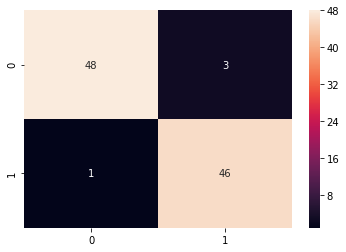

In [16]:
#Matrice de confusion
def matrice_confusion(modele) :
  predicted_probs = modele.predict_generator(
      validate_generator(test_files, test_labels, WAVS_PER_BATCH),
      steps=steps_per_epoch(len(test_files), WAVS_PER_BATCH))
  predicted_classes = np.argmax(predicted_probs, axis=1)
  print(sklearn.metrics.accuracy_score(predicted_classes, test_labels))
  sns.heatmap(sklearn.metrics.confusion_matrix(predicted_classes, test_labels), annot=True);

matrice_confusion(model)

**Test indépendant :**

In [0]:
# test sur un wav particulier
#aFile = "/content/sample_data/cats_dogs/test/cats/cat_110.wav"
def shape_to_predict(sons) :
  waves = []
  
  for son in sons :
    wave_raw = wavfile.read(son)[1]
    wave_raw = wave_raw/np.std(wave_raw)
    length = len(wave_raw)
    left = 0
    right = MAX_WAV_SAMPLES - left - length
    wave = np.pad(wave_raw, pad_width=((left, right)), mode='wrap')
    wave = wave.reshape( (1,wave.size) )

    if len(waves) == 0 :
      waves = wave
    else :
      waves = np.concatenate((waves, wave), axis = 0)

  return waves

def predict_model(sons) :
  resu = model.predict(sons)
  reps = []
  for i in resu :
    rep = np.argmax(i)
    if rep == 0 :
      reps.append("cat")
    else :
      reps.append("dogs")
  return reps




In [50]:
aFile = ["/content/sample_data/cats_dogs/train/cat/cat_1.wav"]
test = shape_to_predict(aFile)
reps = predict_model(test)
for i in range(len(test)) :
  if "cat_" in aFile[i] :
    predict = "cat"
  else :
    predict = "dog"
  print("prédiction : {} ; réponse : {}".format(reps[i], predict))

prédiction : cat ; réponse : cat


In [54]:
files = ["/content/sample_data/cats_dogs/test/cats/cat_110.wav","/content/sample_data/cats_dogs/train/dog/dog_barking_10.wav"]
test = shape_to_predict(files)
reps = predict_model(test)
test.shape
for i in range(len(test)) :
  if "cat_" in files[i] :
    predict = "cat"
  else :
    predict = "dog"
  print("prédiction : {} ; réponse : {}".format(reps[i], predict))

prédiction : cat ; réponse : cat
prédiction : dogs ; réponse : dog


**Récupération des sauvegardes :**

In [56]:
!ls "$checkpoint_dir"

checkpoint		     cp-0008.data-00000-of-00002
cp-0000.data-00000-of-00002  cp-0008.data-00001-of-00002
cp-0000.data-00001-of-00002  cp-0008.index
cp-0000.index		     cp-0009.data-00000-of-00002
cp-0001.data-00000-of-00002  cp-0009.data-00001-of-00002
cp-0001.data-00001-of-00002  cp-0009.index
cp-0001.index		     cp-0010.data-00000-of-00002
cp-0002.data-00000-of-00002  cp-0010.data-00001-of-00002
cp-0002.data-00001-of-00002  cp-0010.index
cp-0002.index		     cp-0011.data-00000-of-00002
cp-0003.data-00000-of-00002  cp-0011.data-00001-of-00002
cp-0003.data-00001-of-00002  cp-0011.index
cp-0003.index		     cp-0012.data-00000-of-00002
cp-0004.data-00000-of-00002  cp-0012.data-00001-of-00002
cp-0004.data-00001-of-00002  cp-0012.index
cp-0004.index		     cp-0013.data-00000-of-00002
cp-0005.data-00000-of-00002  cp-0013.data-00001-of-00002
cp-0005.data-00001-of-00002  cp-0013.index
cp-0005.index		     cp-0014.data-00000-of-00002
cp-0006.data-00000-of-00002  cp-0014.data-00001-of-00002
cp-0006.da

0.5


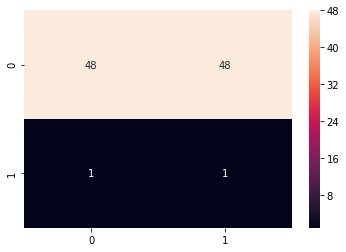

In [57]:
#Création d'un model non entraîner
modelRecup = create_model()
matrice_confusion(modelRecup)

0.9591836734693877


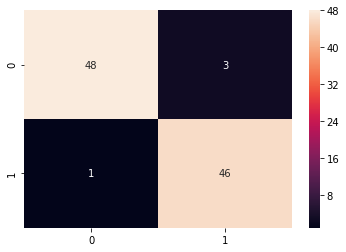

In [59]:
#Récupération du model à l'epoch 15
modelRecup.load_weights(checkpoint_path.format(epoch=15))
matrice_confusion(modelRecup)